<a href="https://colab.research.google.com/github/rimi0602/Medicinal_Plant_Identification_Using_Resnet/blob/main/Leaf_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd

Mounted at /content/drive/
/root


In [2]:
#importing libraries
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Model, save_model

import matplotlib.pyplot as plt
import seaborn as sb

from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import os #  to interact with files using there paths
from sklearn.datasets import load_files

In [4]:
#The path of our data on drive
directory =  r'/content/drive/MyDrive/Leafs'

In [6]:
folders=os.listdir("/content/drive/MyDrive/Leafs")
print(folders)

['Syzygium Cumini (Jamun)', 'Syzygium Jambos (Rose Apple)', 'Piper Betle (Betel)', 'Punica Granatum (Pomegranate)', 'Plectranthus Amboinicus (Mexican Mint)', 'Tabernaemontana Divaricata (Crape Jasmine)', 'Psidium Guajava (Guava)', 'Santalum Album (Sandalwood)', 'Trigonella Foenum-graecum (Fenugreek)', 'Pongamia Pinnata (Indian Beech)', 'Moringa Oleifera (Drumstick)', 'Mentha (Mint)', 'Jasminum (Jasmine)', 'Nyctanthes Arbor-tristis (Parijata)', 'Hibiscus Rosa-sinensis', 'Nerium Oleander (Oleander)', 'Muntingia Calabura (Jamaica Cherry-Gasagase)', 'Mangifera Indica (Mango)', 'Murraya Koenigii (Curry)', 'Ocimum Tenuiflorum (Tulsi)', 'Artocarpus Heterophyllus (Jackfruit)', 'Alpinia Galanga (Rasna)', 'Carissa Carandas (Karanda)', 'Amaranthus Viridis (Arive-Dantu)', 'Ficus Religiosa (Peepal Tree)', 'Brassica Juncea (Indian Mustard)', 'Ficus Auriculata (Roxburgh fig)', 'Citrus Limon (Lemon)', 'Basella Alba (Basale)', 'Azadirachta Indica (Neem)', 'Leaf', 'medicinal_plant_identification_model.h

In [7]:
batch_size = 64
IMG_SIZE = (224, 224, 3)

In [8]:
#creating train data set
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True,
    )

Found 1542 files belonging to 31 classes.
Using 1234 files for training.


In [9]:
#creating train validation set
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_SIZE[0], IMG_SIZE[1]),
    batch_size=batch_size,
    shuffle=True
    )

Found 1542 files belonging to 31 classes.
Using 308 files for validation.


In [10]:
#getting the name of classes
class_names = train_ds.class_names

In [12]:
import os
if not os.path.exists("../artifacts"):
    !mkdir ../artifacts
#saving class names
np.save("../artifacts/class_names.npy", class_names)

In [13]:
!ls ../artifacts

class_names.npy


In [14]:
NUM_CLASSES = 31

***Sample of traning data***

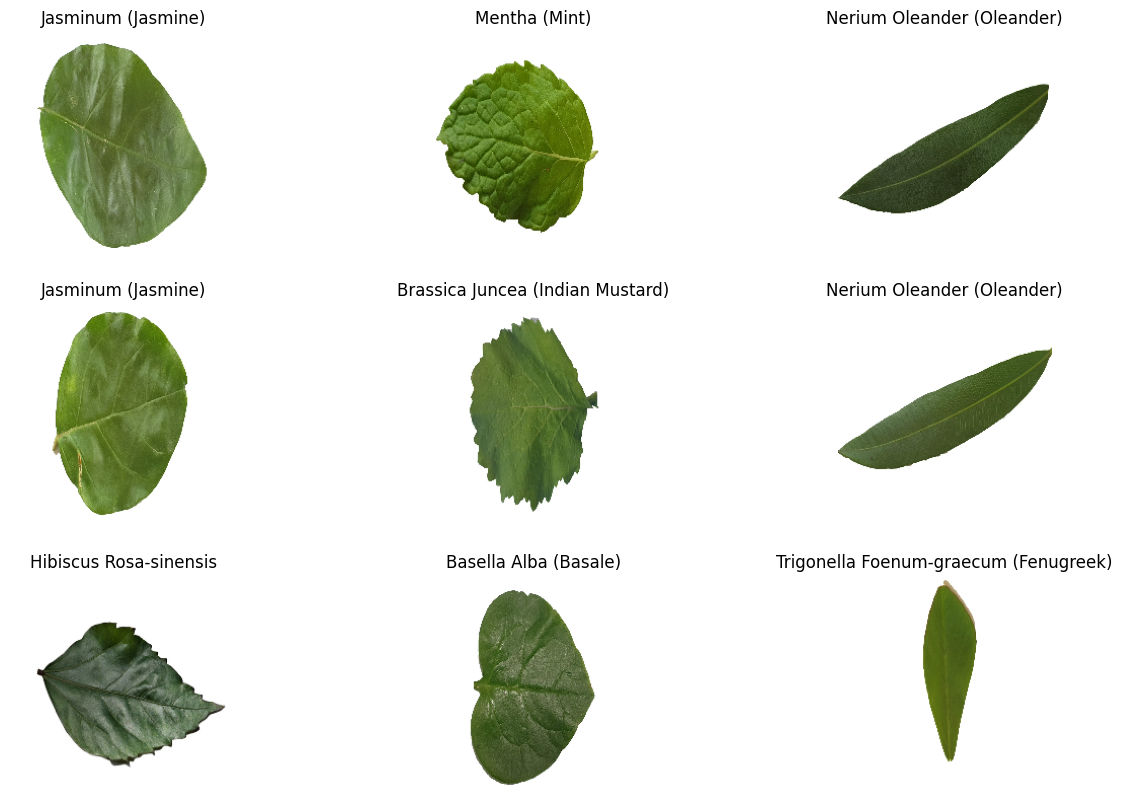

In [15]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [16]:
#provides pipeling for reading data and training
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
validation_ds = validation_ds.cache().prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

***Modelling***

In [17]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        keras.layers.Rescaling(1./ 255),
        keras.layers.RandomFlip(),
        keras.layers.RandomRotation(0.2),
        keras.layers.RandomZoom(0.2,0.3)
    ]
)

In [18]:
#ResNet50V2 layers except for the last global average pooling and final dense layer.
pre_trained_layers = keras.applications.ResNet50V2(weights="imagenet", include_top=False,
           input_tensor=keras.Input(shape=IMG_SIZE))

94668760/94668760 [==============================] - 1s 0us/step


In [19]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [20]:
#freezing the layers of ResNet
pre_trained_layers.trainable = False

In [21]:
pre_trained_layers.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [22]:
#Creating custom model
model = keras.Sequential([
    data_augmentation,                                                    # data augmentations
    pre_trained_layers,                                                   # ResNet pre-trained layers
    keras.layers.GlobalAveragePooling2D(),                                # Adding Global average Pooling 2d
    keras.layers.Dense(NUM_CLASSES, activation='softmax', name='output')  # Final Dense Layer with 30 neurons
])

In [23]:
EPOCHS = 10
LR = 1e-3

In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [25]:
#printing summary of custom model
model.build((1,224,224,3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (1, 224, 224, 3)          0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (1, 2048)                 0         
 GlobalAveragePooling2D)                                         
                                                                 
 output (Dense)              (1, 31)                   63519     
                                                                 
Total params: 23628319 (90.13 MB)
Trainable params: 63519 (248.12 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [26]:
# Callback -> Reduce Learning Rate on Plateau
callback = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1, mode='auto',
                             min_delta=0.0001, cooldown=0, min_lr=0.00001)

In [27]:
#training the model
history = model.fit(train_ds, epochs=EPOCHS, validation_data=validation_ds, callbacks=callback)

Epoch 1/10
20/20 [==============================] - 345s 17s/step - loss: 2.6040 - accuracy: 0.3258 - val_loss: 1.4684 - val_accuracy: 0.6331 - lr: 0.0010
Epoch 2/10
20/20 [==============================] - 318s 16s/step - loss: 1.2027 - accuracy: 0.7269 - val_loss: 0.8564 - val_accuracy: 0.8247 - lr: 0.0010
Epoch 3/10
20/20 [==============================] - 284s 14s/step - loss: 0.7731 - accuracy: 0.8549 - val_loss: 0.6302 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 4/10
20/20 [==============================] - 310s 16s/step - loss: 0.5911 - accuracy: 0.8817 - val_loss: 0.5416 - val_accuracy: 0.8961 - lr: 0.0010
Epoch 5/10
20/20 [==============================] - 282s 14s/step - loss: 0.5014 - accuracy: 0.9052 - val_loss: 0.4713 - val_accuracy: 0.9091 - lr: 0.0010
Epoch 6/10
20/20 [==============================] - 311s 16s/step - loss: 0.4464 - accuracy: 0.9044 - val_loss: 0.4348 - val_accuracy: 0.9058 - lr: 0.0010
Epoch 7/10
20/20 [==============================] - 315s 16s/step - lo

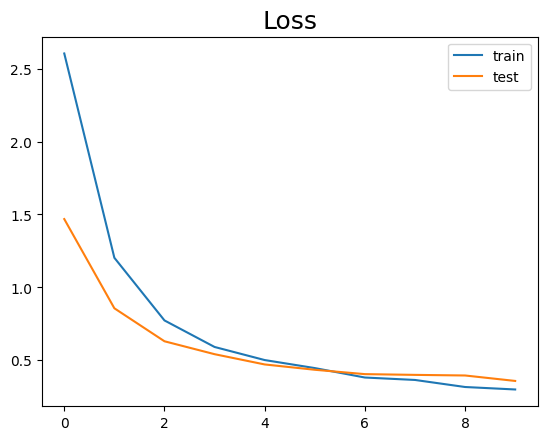

In [28]:
plt.title("Loss", fontdict={'fontsize':18})
plt.plot(history.history['loss'],label='train')
plt.plot(history.history['val_loss'],label='test')
plt.legend()
plt.show()

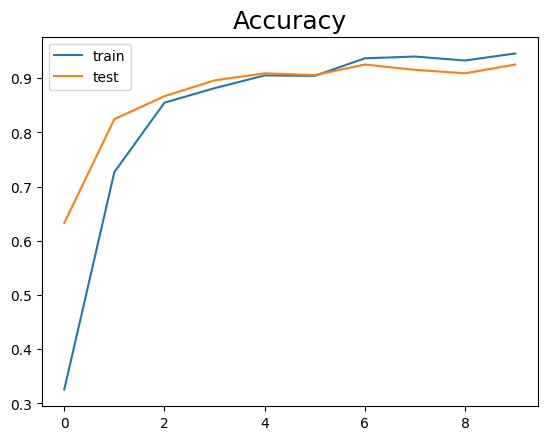

In [29]:
plt.title("Accuracy", fontdict={'fontsize':18})
plt.plot(history.history['accuracy'],label='train')
plt.plot(history.history['val_accuracy'],label='test')
plt.legend()
plt.show()

***Perfomance analysis***

In [30]:
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px

In [31]:
Y_train = []
X_train = []

In [32]:
for data in train_ds:
    X_train.extend(data[0].numpy())
    Y_train.extend(data[1].numpy())

In [33]:
Y_train = np.array(Y_train)
X_train = np.array(X_train)

In [34]:
y_train_pred_prob = model.predict(X_train)
y_train_pred = [np.argmax(i) for i in y_train_pred_prob]

39/39 [==============================] - 210s 5s/step


In [35]:
y_train_pred_prob.shape

(1234, 31)

In [36]:
#function to plot roc-auc curve
def roc_auc_curve(y_scores, y_true):
    # One hot encode the labels in order to plot them
    y_onehot = pd.get_dummies(y_true, columns=class_names)

    # Create an empty figure, and iteratively add new lines
    # every time we compute a new class
    fig = go.Figure()
    fig.add_shape(
        type='line', line=dict(dash='dash'),
        x0=0, x1=1, y0=0, y1=1
    )

    for i in range(y_scores.shape[1]):
        y_true = y_onehot.iloc[:, i]
        y_score = y_scores[:, i]

        fpr, tpr, _ = roc_curve(y_true, y_score)
        auc_score = roc_auc_score(y_true, y_score)

        name = f"{class_names[i]} (AUC={auc_score:.2f})"
        fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

    fig.update_layout(
        title="ROC Curve",
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        yaxis=dict(scaleanchor="x", scaleratio=1),
        xaxis=dict(constrain='domain'),
        width=900, height=800
    )

    return fig

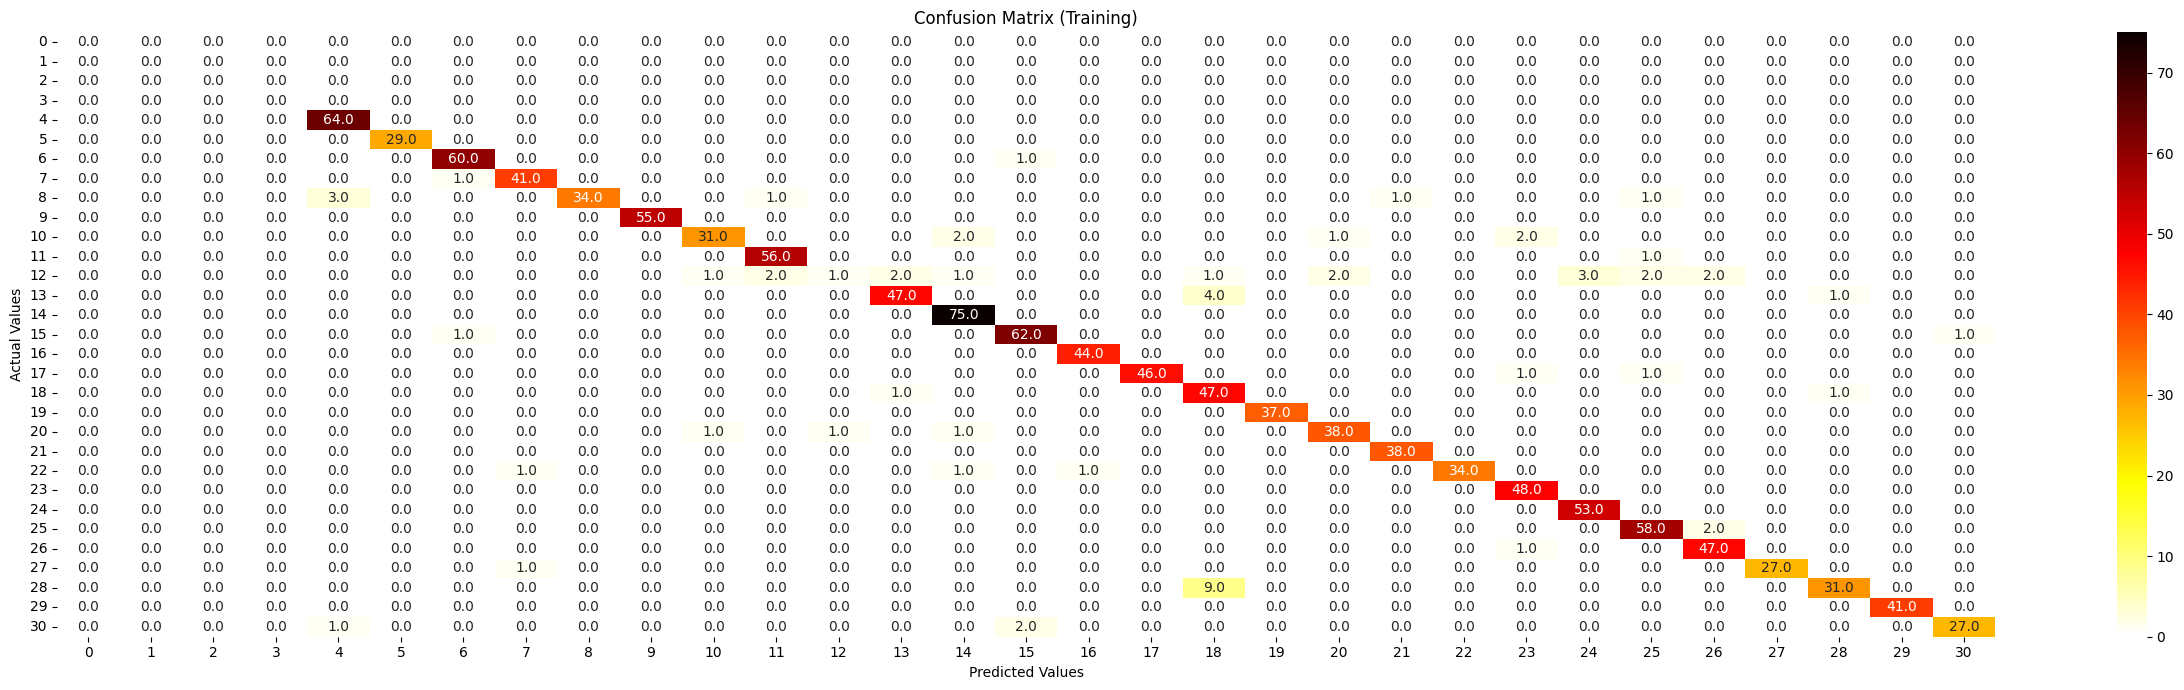

In [37]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=Y_train,predictions=y_train_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix (Training)')
plt.tight_layout()
plt.show()

In [38]:
print("Classification Report for Training")
print(classification_report(Y_train, y_train_pred))

Classification Report for Training
              precision    recall  f1-score   support

           4       0.94      1.00      0.97        64
           5       1.00      1.00      1.00        29
           6       0.97      0.98      0.98        61
           7       0.95      0.98      0.96        42
           8       1.00      0.85      0.92        40
           9       1.00      1.00      1.00        55
          10       0.94      0.86      0.90        36
          11       0.95      0.98      0.97        57
          12       0.50      0.06      0.11        17
          13       0.94      0.90      0.92        52
          14       0.94      1.00      0.97        75
          15       0.95      0.97      0.96        64
          16       0.98      1.00      0.99        44
          17       1.00      0.96      0.98        48
          18       0.77      0.96      0.85        49
          19       1.00      1.00      1.00        37
          20       0.93      0.93      0.93   

In [51]:
X_test = []
y_test = []

In [52]:
for data in validation_ds:
    X_test.extend(data[0].numpy())
    y_test.extend(data[1].numpy())

In [53]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [54]:
y_test_pred_prob = model.predict(X_test)
y_test_pred = [np.argmax(i) for i in y_test_pred_prob]

10/10 [==============================] - 59s 6s/step


In [55]:
np.unique(y_test)

array([ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,
       21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int32)

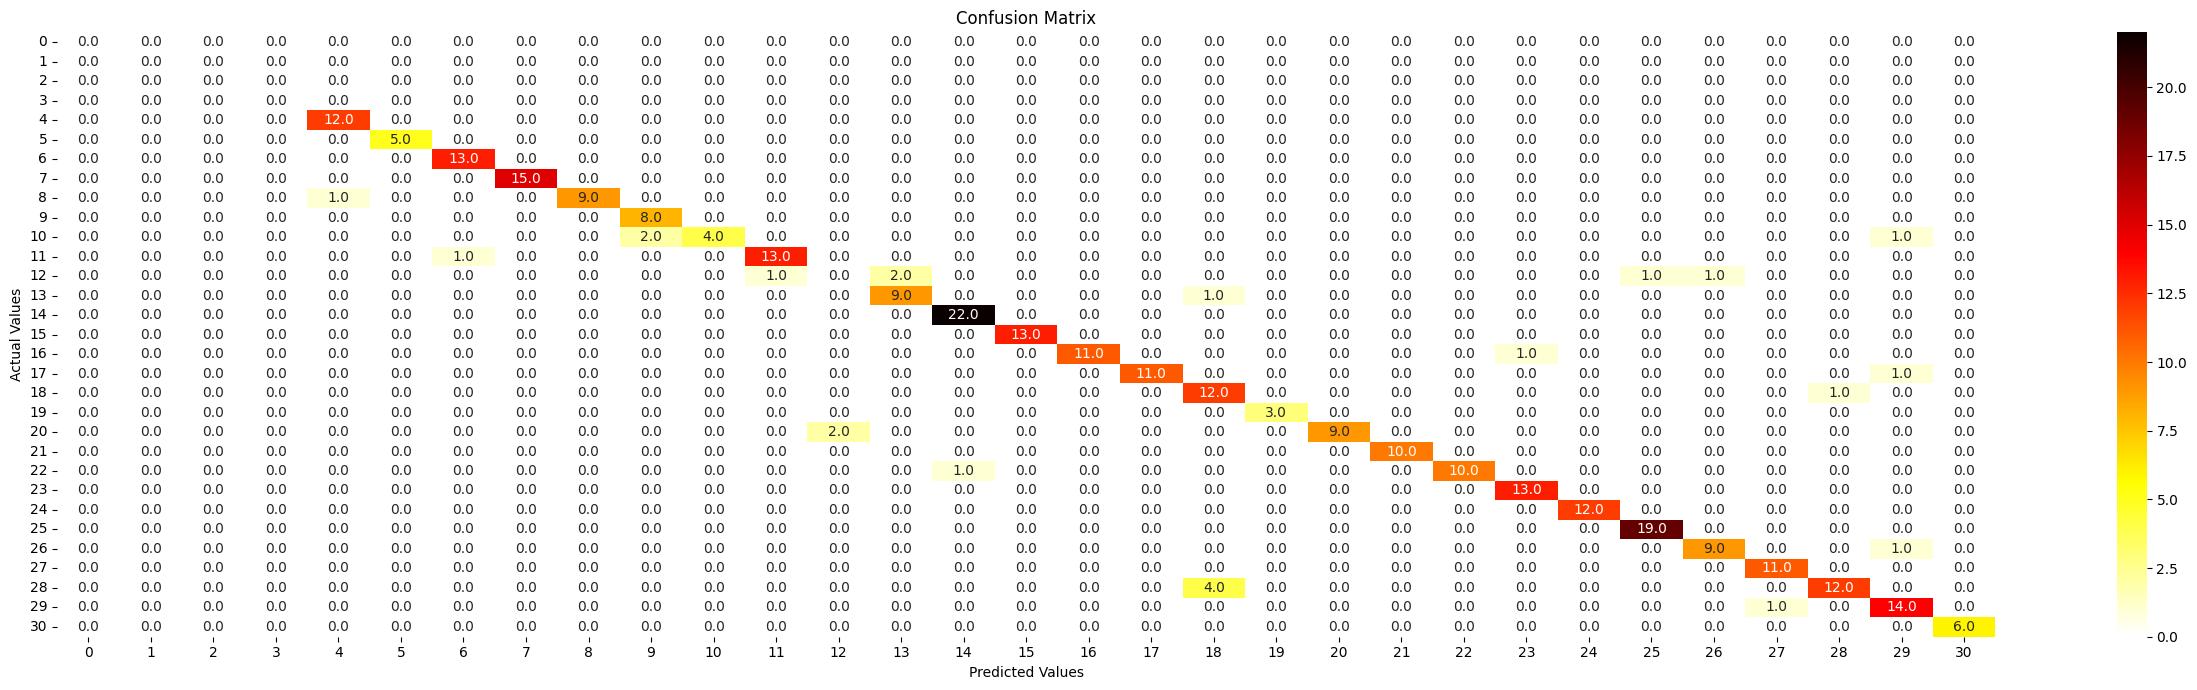

In [56]:
plt.figure(figsize=(25,7))
sb.heatmap(tf.math.confusion_matrix(labels=y_test,predictions=y_test_pred),annot=True,fmt='.1f', cmap='hot_r')
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

In [57]:
print("Classification Report for Test")
print(classification_report(y_test, y_test_pred))

Classification Report for Test
              precision    recall  f1-score   support

           4       0.92      1.00      0.96        12
           5       1.00      1.00      1.00         5
           6       0.93      1.00      0.96        13
           7       1.00      1.00      1.00        15
           8       1.00      0.90      0.95        10
           9       0.80      1.00      0.89         8
          10       1.00      0.57      0.73         7
          11       0.93      0.93      0.93        14
          12       0.00      0.00      0.00         5
          13       0.82      0.90      0.86        10
          14       0.96      1.00      0.98        22
          15       1.00      1.00      1.00        13
          16       1.00      0.92      0.96        12
          17       1.00      0.92      0.96        12
          18       0.71      0.92      0.80        13
          19       1.00      1.00      1.00         3
          20       1.00      0.82      0.90       

In [63]:
import tensorflow as tf

# Define the path to your dataset directory
directory = "/content/drive/MyDrive/Leafs"

# Create an ImageDataGenerator to load the dataset
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load the dataset from the directory
batch_size = 32  # Adjust according to your dataset size
dataset = datagen.flow_from_directory(directory,
                                      target_size=(224, 224),  # Adjust target size as needed
                                      batch_size=batch_size,
                                      class_mode='categorical')  # Assuming you have multiple classes

# Get the true labels
y_true = dataset.classes

Found 1542 images belonging to 31 classes.


In [66]:
y_score = model.predict(X_test)

10/10 [==============================] - 63s 6s/step


In [74]:
print(y_true.shape)
print(y_score.shape)

(1542,)
(308, 31)


In [82]:
from tensorflow.keras.models import save_model

In [83]:
save_model(model, '../Model/model.h5')